In [1]:
%pip install yfinance finta

Note: you may need to restart the kernel to use updated packages.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from finta import TA
from tickerData import *
from mlAlgorithms import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = getTickerData(ticker="btc-usd", period="max", interval="1d")
df.drop(columns={'Volume', 'Adj Close'}, inplace=True)
df.rename(columns={'Date':'date', 'Open':'open', 'High':'high','Low':'low', 'Close':'close'}, inplace=True)
df

[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
3092,2023-03-06,22436.816406,22584.292969,22331.314453,22429.757812
3093,2023-03-07,22428.322266,22527.417969,22011.261719,22219.769531
3094,2023-03-08,22216.441406,22268.896484,21708.050781,21718.080078
3095,2023-03-09,21720.080078,21802.716797,20210.306641,20363.021484


In [3]:
indicators = ['SMA', 'EMA', 'HMA', 'RSI', 'MACD', 'BBANDS']
df = getTickerIndicatorData(df, indicators, dropna=True)
df

,date,open,high,low,close,41 period SMA,9 period EMA,16 period HMA.,14 period RSI,MACD,SIGNAL,BB_UPPER,BB_MIDDLE,BB_LOWER
40,2014-10-27,354.777008,358.631989,349.808990,352.989014,380.788635,363.663991,353.468163,39.026158,-5.157967,-2.096673,407.323340,373.896951,340.470563
41,2014-10-28,353.214996,359.984009,352.678986,357.618011,378.356537,362.454692,349.317459,41.629699,-5.426438,-2.762683,407.000618,374.130852,341.261085
42,2014-10-29,357.088989,357.833008,335.342987,335.591003,376.189488,357.081589,344.547598,34.155922,-7.272277,-3.664663,409.625952,372.659102,335.692252
43,2014-10-30,335.709015,350.912994,335.071991,345.304993,374.982391,354.726141,341.069877,39.328954,-7.883579,-4.508492,410.516219,371.846251,333.176283
44,2014-10-31,345.009003,348.045013,337.141998,338.321014,373.260855,351.444973,338.193822,37.073754,-8.812961,-5.369423,411.960112,370.647351,329.334590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,2023-03-06,22436.816406,22584.292969,22331.314453,22429.757812,23201.094131,22873.506548,22483.784127,43.497180,-52.088259,186.893195,25205.263359,23608.796680,22012.330001
3093,2023-03-07,22428.322266,22527.417969,22011.261719,22219.769531,23179.189501,22742.759145,22315.061410,41.600970,-109.951179,127.524320,25179.541630,23504.393066,21829.244503
3094,2023-03-08,22216.441406,22268.896484,21708.050781,21718.080078,23147.123714,22537.823331,22108.065096,37.405458,-194.053181,63.208820,25262.955226,23409.123340,21555.291454
3095,2023-03-09,21720.080078,21802.716797,20210.306641,20363.021484,23080.886957,22102.862962,21712.382533,28.921326,-365.829474,-22.598839,25417.694800,23198.994336,20980.293872


In [4]:
df.isnull().sum()

date              0
open              0
high              0
low               0
close             0
41 period SMA     0
9 period EMA      0
16 period HMA.    0
14 period RSI     0
MACD              0
SIGNAL            0
BB_UPPER          0
BB_MIDDLE         0
BB_LOWER          0
dtype: int64

In [5]:
df2 = produce_prediction(df, 14, dropna=True, removeohl=True)
df2

,date,close,41 period SMA,9 period EMA,16 period HMA.,14 period RSI,MACD,SIGNAL,BB_UPPER,BB_MIDDLE,BB_LOWER,pred
40,2014-10-27,352.989014,380.788635,363.663991,353.468163,39.026158,-5.157967,-2.096673,407.323340,373.896951,340.470563,1.0
41,2014-10-28,357.618011,378.356537,362.454692,349.317459,41.629699,-5.426438,-2.762683,407.000618,374.130852,341.261085,1.0
42,2014-10-29,335.591003,376.189488,357.081589,344.547598,34.155922,-7.272277,-3.664663,409.625952,372.659102,335.692252,1.0
43,2014-10-30,345.304993,374.982391,354.726141,341.069877,39.328954,-7.883579,-4.508492,410.516219,371.846251,333.176283,1.0
44,2014-10-31,338.321014,373.260855,351.444973,338.193822,37.073754,-8.812961,-5.369423,411.960112,370.647351,329.334590,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3078,2023-02-20,24829.148438,22482.616806,23880.460548,24615.328644,66.127944,729.936592,595.598717,25268.511378,23167.473438,21066.435497,0.0
3079,2023-02-21,24436.353516,22641.188929,23991.639142,24931.111335,62.089375,737.569296,623.992832,25367.086027,23203.102637,21039.119247,0.0
3080,2023-02-22,24188.843750,22770.926877,24031.080064,25055.371428,59.618588,715.399618,642.274189,25445.027143,23238.951270,21032.875396,0.0
3081,2023-02-23,23947.492188,22869.412681,24014.362488,24989.873572,57.227131,670.624394,647.944230,25491.084932,23263.859766,21036.634600,0.0


In [7]:
df2.isnull().sum()

date              0
close             0
41 period SMA     0
9 period EMA      0
16 period HMA.    0
14 period RSI     0
MACD              0
SIGNAL            0
BB_UPPER          0
BB_MIDDLE         0
BB_LOWER          0
pred              0
dtype: int64

In [8]:
features = StandardScaler().fit_transform(df2[df2.columns.difference(['pred', 'date'])])
target = df2['pred']

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.4, shuffle=False)
X_train.shape

(1825, 10)

{'n_neighbors': 23}
              precision    recall  f1-score   support

         0.0       0.50      0.91      0.65       563
         1.0       0.74      0.22      0.34       655

    accuracy                           0.54      1218
   macro avg       0.62      0.57      0.50      1218
weighted avg       0.63      0.54      0.48      1218

{'C': 0.1, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.49      0.98      0.65       563
         1.0       0.86      0.12      0.20       655

    accuracy                           0.51      1218
   macro avg       0.68      0.55      0.43      1218
weighted avg       0.69      0.51      0.41      1218

{'n_estimators': 190}
              precision    recall  f1-score   support

         0.0       0.49      0.96      0.65       563
         1.0       0.81      0.15      0.26       655

    accuracy                           0.53      1218
   macro avg       0.65      0.56      0.45      1218
we

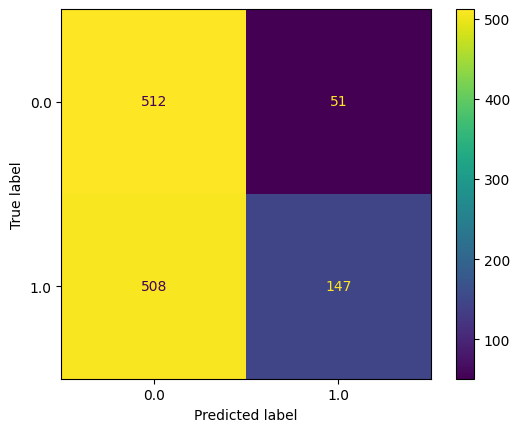

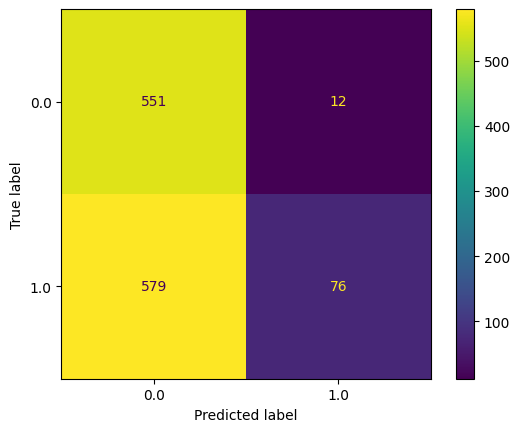

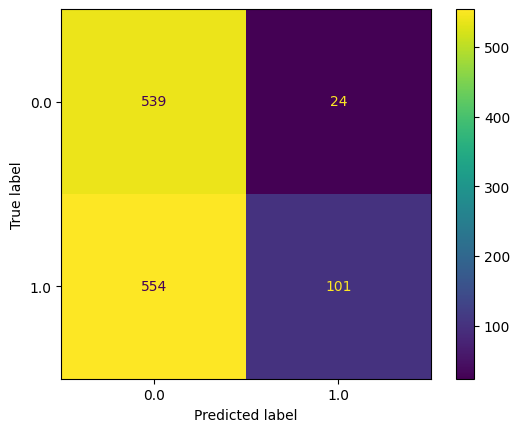

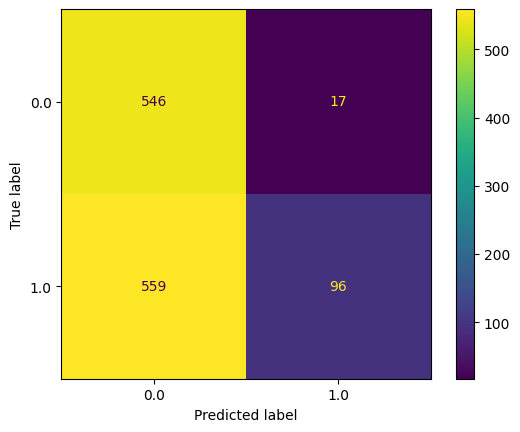

In [9]:
knn = trained_KNN(X_train, X_test, Y_train, Y_test)
lr = trained_LogisticRegression(X_train, X_test, Y_train, Y_test)
rfc = trained_RandomForestClassifier(X_train, X_test, Y_train, Y_test)
vc = trained_VotingClassifier(lr, knn, rfc, X_train, X_test, Y_train, Y_test)

In [11]:
print('knn -', metrics.accuracy_score(df2['pred'], knn.predict(features)))
print('lr -', metrics.accuracy_score(df2['pred'], lr.predict(features)))
print('rfc -', metrics.accuracy_score(df2['pred'], rfc.predict(features)))
print('vc -', metrics.accuracy_score(df2['pred'], vc.predict(features)))

knn - 0.6398291160039434
lr - 0.5934932632270785
rfc - 0.6010515938218863
vc - 0.6125534012487677
